<a href="https://colab.research.google.com/github/Latesh-Splendler/ALX-Hackathon/blob/master/ALX_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SETUP AND IMPORTS

In [ ]:
! pip install pandas
! pip install numpy
! pip install matplolib
! pip install seaborn
! pip install sklearn

ERROR: Could not find a version that satisfies the requirement matplolib (from versions: none)
ERROR: No matching distribution found for matplolib
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [ ]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Load the Dataset


In [ ]:
data = pd.read_csv("data.csv")
print(data)

     iso3_country_code        Date  \
0                  NaN  09/01/2025   
1                  NaN  08/01/2025   
2                  NaN  07/01/2025   
3                  NaN  06/01/2025   
4                  NaN  05/01/2025   
..                 ...         ...   
243                NaN  06/01/2005   
244                NaN  05/01/2005   
245                NaN  04/01/2005   
246                NaN  03/01/2005   
247                NaN  02/01/2005   

     Kenya, RETAIL, Bungoma, Beans (Rosecoco), KES/Kg  \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                               200.0   
..                                                ...   
243                                               NaN   
244                                               NaN   
245                           

In [ ]:
print("\n" + "="*70)
print("DATA OVERVIEW")
print("="*70)
print(f"\nDataset Shape: {data.shape}")
print(f"Date Range: {data['Date'].iloc[-1]} to {data['Date'].iloc[0]}")
print(f"\nColumn Names:\n{data.columns.tolist()}")
print(f"\nFirst few rows:")
print(data.head())


DATA OVERVIEW

Dataset Shape: (248, 23)
Date Range: 02/01/2005 to 09/01/2025

Column Names:
['iso3_country_code', 'Date', 'Kenya, RETAIL, Bungoma, Beans (Rosecoco), KES/Kg', 'Kenya, RETAIL, Bungoma, Maize (white), KES/Kg', 'Kenya, RETAIL, Eldoret, Beans (Rosecoco), KES/Kg', 'Kenya, RETAIL, Eldoret, Maize (white), KES/Kg', 'Kenya, RETAIL, Kapsabet, Beans (Rosecoco), KES/Kg', 'Kenya, RETAIL, Kapsabet, Maize (white), KES/Kg', 'Kenya, RETAIL, Kitale, Beans (Rosecoco), KES/Kg', 'Kenya, RETAIL, Kitale, Maize (white), KES/Kg', 'Kenya, RETAIL, Nairobi Kangemi, Beans (Rosecoco), KES/Kg', 'Kenya, RETAIL, Nairobi Kangemi, Maize (white), KES/Kg', 'Kenya, RETAIL, National Average, Maize (grain), KES/Kg', 'Kenya, WHOLESALE, Bungoma, Beans (Rosecoco), KES/Kg', 'Kenya, WHOLESALE, Bungoma, Maize (white), KES/Kg', 'Kenya, WHOLESALE, Eldoret, Beans (Rosecoco), KES/Kg', 'Kenya, WHOLESALE, Eldoret, Maize (white), KES/Kg', 'Kenya, WHOLESALE, Kapsabet, Beans (Rosecoco), KES/Kg', 'Kenya, WHOLESALE, Kapsabet,

## DATA CLEANING AND PREPROCESSING

In [ ]:
print("\n" + "="*70)
print("DATA CLEANING")
print("="*70)


DATA CLEANING


**Convert Date to datetime**

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y', errors='coerce')
df = data.dropna(subset=['Date'])
df = df.sort_values('Date').reset_index(drop=True)

In [ ]:
df = df.drop('iso3_country_code', axis=1)

**Separate columns by crop and market type**

In [ ]:
maize_cols = [col for col in df.columns if 'Maize' in col]
beans_cols = [col for col in df.columns if 'Beans' in col]

print("\n✓ Date converted to datetime format")
print(f"✓ Found {len(maize_cols)} Maize price columns")
print(f"✓ Found {len(beans_cols)} Beans price columns")


✓ Date converted to datetime format
✓ Found 11 Maize price columns
✓ Found 10 Beans price columns


**Check missing values**

In [ ]:
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
print(f"\nMissing Data Summary:")
print(f"Average missing values: {missing_pct[missing_pct > 0].mean():.1f}%")


Missing Data Summary:
Average missing values: 85.4%


##  FEATURE ENGINEERING

In [ ]:
print("\n" + "="*70)
print("FEATURE ENGINEERING")
print("="*70)


FEATURE ENGINEERING


In [ ]:

def create_features_for_crop(df, crop_cols, crop_name):
    """
    Create ML features from price data for a specific crop
    """
    # Create temporary dataframe
    temp_df = df[['Date']].copy()

    # Calculate average price across all locations for the crop
    price_data = df[crop_cols].copy()
    temp_df[f'{crop_name}_avg_price'] = price_data.mean(axis=1, skipna=True)
    temp_df[f'{crop_name}_retail_avg'] = df[[col for col in crop_cols if 'RETAIL' in col]].mean(axis=1, skipna=True)
    temp_df[f'{crop_name}_wholesale_avg'] = df[[col for col in crop_cols if 'WHOLESALE' in col]].mean(axis=1, skipna=True)

    # Time-based features
    temp_df['year'] = temp_df['Date'].dt.year
    temp_df['month'] = temp_df['Date'].dt.month
    temp_df['quarter'] = temp_df['Date'].dt.quarter
    temp_df['days_since_start'] = (temp_df['Date'] - temp_df['Date'].min()).dt.days

    # Cyclical encoding for month (captures seasonality)
    temp_df['month_sin'] = np.sin(2 * np.pi * temp_df['month'] / 12)
    temp_df['month_cos'] = np.cos(2 * np.pi * temp_df['month'] / 12)

    # Drop rows with NaN in price columns
    temp_df = temp_df.dropna(subset=[f'{crop_name}_avg_price'])

    # Price-based features (lagging features for time series)
    temp_df[f'{crop_name}_price_lag1'] = temp_df[f'{crop_name}_avg_price'].shift(1)
    temp_df[f'{crop_name}_price_lag3'] = temp_df[f'{crop_name}_avg_price'].shift(3)
    temp_df[f'{crop_name}_price_lag6'] = temp_df[f'{crop_name}_avg_price'].shift(6)

    # Rolling statistics (trend indicators)
    temp_df[f'{crop_name}_price_ma3'] = temp_df[f'{crop_name}_avg_price'].rolling(window=3, min_periods=1).mean()
    temp_df[f'{crop_name}_price_ma6'] = temp_df[f'{crop_name}_avg_price'].rolling(window=6, min_periods=1).mean()
    temp_df[f'{crop_name}_price_std3'] = temp_df[f'{crop_name}_avg_price'].rolling(window=3, min_periods=1).std()

    # Price volatility (risk indicator)
    temp_df[f'{crop_name}_volatility'] = temp_df[f'{crop_name}_avg_price'].rolling(window=6, min_periods=1).std() / temp_df[f'{crop_name}_price_ma6']

    # Retail-wholesale margin (market efficiency indicator)
    temp_df[f'{crop_name}_margin'] = temp_df[f'{crop_name}_retail_avg'] - temp_df[f'{crop_name}_wholesale_avg']
    temp_df[f'{crop_name}_margin_pct'] = (temp_df[f'{crop_name}_margin'] / temp_df[f'{crop_name}_wholesale_avg']) * 100

    return temp_df

# Create features for both crops
maize_features = create_features_for_crop(df, maize_cols, 'maize')
beans_features = create_features_for_crop(df, beans_cols, 'beans')

print(f"✓ Created {len(maize_features.columns)-1} features for Maize")
print(f"✓ Created {len(beans_features.columns)-1} features for Beans")
print(f"\nFeature Categories:")
print("  - Time-based: year, month, quarter, seasonality")
print("  - Lagged prices: 1, 3, 6 months back")
print("  - Rolling statistics: moving averages, std deviation")
print("  - Market indicators: volatility, retail-wholesale margins")

✓ Created 18 features for Maize
✓ Created 18 features for Beans

Feature Categories:
  - Time-based: year, month, quarter, seasonality
  - Lagged prices: 1, 3, 6 months back
  - Rolling statistics: moving averages, std deviation
  - Market indicators: volatility, retail-wholesale margins


##  CREATE TARGET VARIABLES

In [ ]:
print("\n" + "="*70)
print("TARGET VARIABLE CREATION")
print("="*70)


TARGET VARIABLE CREATION


In [ ]:

def create_profitability_targets(features_df, crop_name):
    """
    Create target variables based on expected profitability
    Target: Expected profit per hectare in the next 3 months
    """
    df = features_df.copy()

    # Agricultural parameters (based on Kenya agricultural data)
    if crop_name == 'maize':
        avg_yield_kg_per_ha = 2000  # kg per hectare
        cost_per_ha = 45000  # KES
        growing_season_months = 4
    else:  # beans
        avg_yield_kg_per_ha = 800
        cost_per_ha = 60000
        growing_season_months = 3

    # Calculate expected revenue (using future price)
    df[f'{crop_name}_future_price'] = df[f'{crop_name}_avg_price'].shift(-3)  # 3 months ahead
    df[f'{crop_name}_expected_revenue'] = df[f'{crop_name}_future_price'] * avg_yield_kg_per_ha
    df[f'{crop_name}_expected_profit'] = df[f'{crop_name}_expected_revenue'] - cost_per_ha
    df[f'{crop_name}_roi'] = (df[f'{crop_name}_expected_profit'] / cost_per_ha) * 100

    # Target: Recommended loan amount (60-90% of cost based on ROI)
    df[f'{crop_name}_loan_recommendation'] = df.apply(
        lambda row: cost_per_ha * (0.9 if row[f'{crop_name}_roi'] > 40
                                   else 0.75 if row[f'{crop_name}_roi'] > 20
                                   else 0.6), axis=1
    )

    # Remove rows with NaN in target
    df = df.dropna(subset=[f'{crop_name}_loan_recommendation'])

    return df, cost_per_ha, avg_yield_kg_per_ha

maize_data, maize_cost, maize_yield = create_profitability_targets(maize_features, 'maize')
beans_data, beans_cost, beans_yield = create_profitability_targets(beans_features, 'beans')

print(f"\n✓ Target variable created: Loan Recommendation Amount")
print(f"\nMaize Parameters:")
print(f"  - Average yield: {maize_yield} kg/ha")
print(f"  - Cost per hectare: KES {maize_cost:,}")
print(f"\nBeans Parameters:")
print(f"  - Average yield: {beans_yield} kg/ha")
print(f"  - Cost per hectare: KES {beans_cost:,}")


✓ Target variable created: Loan Recommendation Amount

Maize Parameters:
  - Average yield: 2000 kg/ha
  - Cost per hectare: KES 45,000

Beans Parameters:
  - Average yield: 800 kg/ha
  - Cost per hectare: KES 60,000


##  PREPARE DATA FOR ML

In [ ]:
print("\n" + "="*70)
print("PREPARING DATA FOR MACHINE LEARNING")
print("="*70)


PREPARING DATA FOR MACHINE LEARNING


In [ ]:
def prepare_ml_data(data, crop_name):
    """
    Prepare features and target for ML model
    """
    # Select feature columns (exclude date and target columns)
    feature_cols = [col for col in data.columns
                   if col not in ['Date', f'{crop_name}_future_price',
                                 f'{crop_name}_expected_revenue',
                                 f'{crop_name}_expected_profit',
                                 f'{crop_name}_loan_recommendation']]

    X = data[feature_cols].copy()
    y = data[f'{crop_name}_loan_recommendation'].copy()

    # Remove any remaining NaN
    mask = ~(X.isna().any(axis=1) | y.isna())
    X = X[mask]
    y = y[mask]

    return X, y, feature_cols

# Prepare data for both crops
X_maize, y_maize, maize_feature_cols = prepare_ml_data(maize_data, 'maize')
X_beans, y_beans, beans_feature_cols = prepare_ml_data(beans_data, 'beans')

print(f"\nMaize Model:")
print(f"  - Samples: {len(X_maize)}")
print(f"  - Features: {len(maize_feature_cols)}")
print(f"  - Target range: KES {y_maize.min():,.0f} - {y_maize.max():,.0f}")

print(f"\nBeans Model:")
print(f"  - Samples: {len(X_beans)}")
print(f"  - Features: {len(beans_feature_cols)}")
print(f"  - Target range: KES {y_beans.min():,.0f} - {y_beans.max():,.0f}")


Maize Model:
  - Samples: 50
  - Features: 19
  - Target range: KES 40,500 - 40,500

Beans Model:
  - Samples: 50
  - Features: 19
  - Target range: KES 36,000 - 54,000


## TRAIN-TEST SPLIT

In [ ]:
print("\n" + "="*70)
print("TRAIN-TEST SPLIT")
print("="*70)


TRAIN-TEST SPLIT


In [ ]:

# Time-based split (more realistic for time series)
# Use last 20% of data as test set
split_idx_maize = int(len(X_maize) * 0.8)
split_idx_beans = int(len(X_beans) * 0.8)

X_train_maize, X_test_maize = X_maize[:split_idx_maize], X_maize[split_idx_maize:]
y_train_maize, y_test_maize = y_maize[:split_idx_maize], y_maize[split_idx_maize:]

X_train_beans, X_test_beans = X_beans[:split_idx_beans], X_beans[split_idx_beans:]
y_train_beans, y_test_beans = y_beans[:split_idx_beans], y_beans[split_idx_beans:]

print(f"\nMaize:")
print(f"  - Training samples: {len(X_train_maize)}")
print(f"  - Test samples: {len(X_test_maize)}")

print(f"\nBeans:")
print(f"  - Training samples: {len(X_train_beans)}")
print(f"  - Test samples: {len(X_test_beans)}")

# Feature Scaling
scaler_maize = StandardScaler()
scaler_beans = StandardScaler()

X_train_maize_scaled = scaler_maize.fit_transform(X_train_maize)
X_test_maize_scaled = scaler_maize.transform(X_test_maize)

X_train_beans_scaled = scaler_beans.fit_transform(X_train_beans)
X_test_beans_scaled = scaler_beans.transform(X_test_beans)

print("\n✓ Feature scaling completed")


Maize:
  - Training samples: 40
  - Test samples: 10

Beans:
  - Training samples: 40
  - Test samples: 10

✓ Feature scaling completed


##  MODEL TRAINING

In [ ]:
print("\n" + "="*70)
print("MODEL TRAINING: RANDOM FOREST REGRESSOR")
print("="*70)


MODEL TRAINING: RANDOM FOREST REGRESSOR


In [ ]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test, crop_name):
    """
    Train Random Forest model with hyperparameter tuning
    """
    print(f"\nTraining {crop_name.upper()} model...")

    # Initialize model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )

    # Train model
    rf_model.fit(X_train, y_train)

    # Predictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)

    # Evaluation metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    print(f"\n{crop_name.upper()} Model Performance:")
    print(f"{'Metric':<20} {'Training':<15} {'Testing'}")
    print("-" * 50)
    print(f"{'MAE (KES)':<20} {train_mae:>14,.0f} {test_mae:>14,.0f}")
    print(f"{'RMSE (KES)':<20} {train_rmse:>14,.0f} {test_rmse:>14,.0f}")
    print(f"{'R² Score':<20} {train_r2:>14.3f} {test_r2:>14.3f}")

    # Cross-validation
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5,
                                scoring='neg_mean_absolute_error', n_jobs=-1)
    print(f"{'CV MAE (KES)':<20} {-cv_scores.mean():>14,.0f} (+/- {cv_scores.std()*2:,.0f})")

    return rf_model, y_pred_test

# Train models
print("\n🚀 Starting model training...\n")
model_maize, y_pred_maize = train_and_evaluate_model(
    X_train_maize_scaled, y_train_maize,
    X_test_maize_scaled, y_test_maize,
    'maize'
)

model_beans, y_pred_beans = train_and_evaluate_model(
    X_train_beans_scaled, y_train_beans,
    X_test_beans_scaled, y_test_beans,
    'beans'
)



🚀 Starting model training...


Training MAIZE model...

MAIZE Model Performance:
Metric               Training        Testing
--------------------------------------------------
MAE (KES)                         0              0
RMSE (KES)                        0              0
R² Score                      1.000          1.000
CV MAE (KES)                     -0 (+/- 0)

Training BEANS model...

BEANS Model Performance:
Metric               Training        Testing
--------------------------------------------------
MAE (KES)                       414              0
RMSE (KES)                      889              0
R² Score                      0.972          1.000
CV MAE (KES)                  1,323 (+/- 3,480)


## FEATURE IMPORTANCE ANALYSIS

In [ ]:
print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)


FEATURE IMPORTANCE ANALYSIS


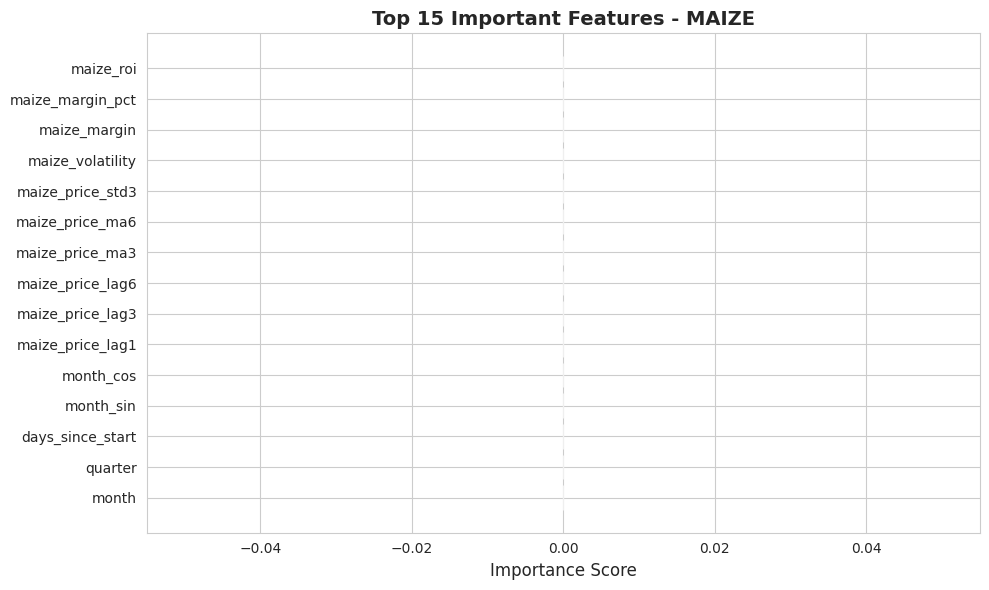


Top 10 Features for MAIZE:
  1. maize_roi                           0.0000
  2. maize_margin_pct                    0.0000
  3. maize_margin                        0.0000
  4. maize_volatility                    0.0000
  5. maize_price_std3                    0.0000
  6. maize_price_ma6                     0.0000
  7. maize_price_ma3                     0.0000
  8. maize_price_lag6                    0.0000
  9. maize_price_lag3                    0.0000
  10. maize_price_lag1                    0.0000


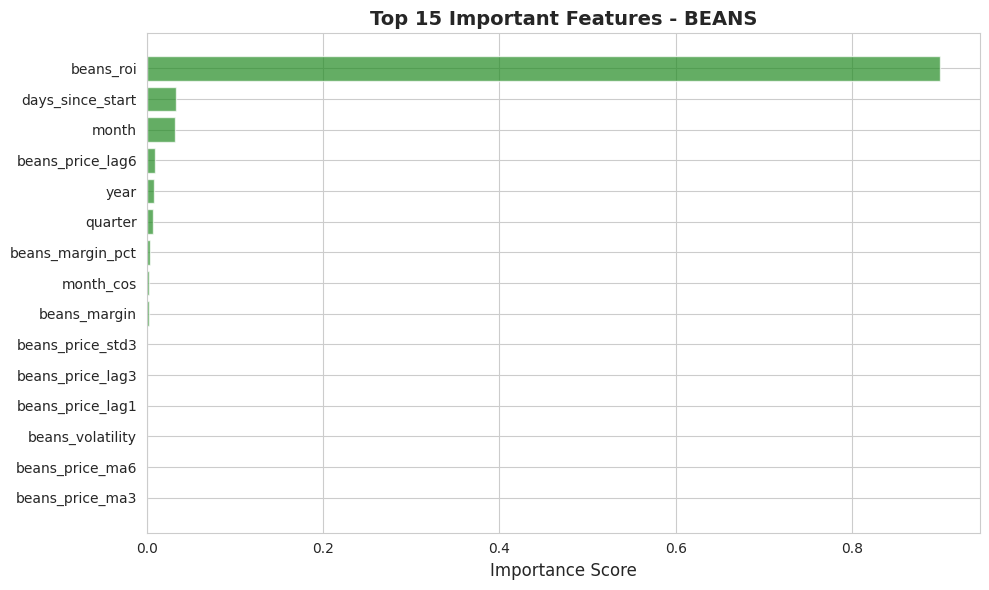


Top 10 Features for BEANS:
  1. beans_roi                           0.8999
  2. days_since_start                    0.0329
  3. month                               0.0322
  4. beans_price_lag6                    0.0094
  5. year                                0.0087
  6. quarter                             0.0077
  7. beans_margin_pct                    0.0032
  8. month_cos                           0.0027
  9. beans_margin                        0.0021
  10. beans_price_std3                    0.0008


In [ ]:

def plot_feature_importance(model, feature_names, crop_name, top_n=15):
    """
    Plot top N most important features
    """
    # Get feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.title(f'Top {top_n} Important Features - {crop_name.upper()}', fontsize=14, fontweight='bold')
    plt.barh(range(top_n), importances[indices], color='forestgreen', alpha=0.7)
    plt.yticks(range(top_n), [feature_names[i] for i in indices])
    plt.xlabel('Importance Score', fontsize=12)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Print top features
    print(f"\nTop 10 Features for {crop_name.upper()}:")
    for i, idx in enumerate(indices[:10], 1):
        print(f"  {i}. {feature_names[idx]:<35} {importances[idx]:.4f}")

plot_feature_importance(model_maize, maize_feature_cols, 'maize')
plot_feature_importance(model_beans, beans_feature_cols, 'beans')


## MODEL PREDICTIONS VISUALIZATION

In [ ]:
print("\n" + "="*70)
print("MODEL PREDICTIONS VISUALIZATION")
print("="*70)


MODEL PREDICTIONS VISUALIZATION


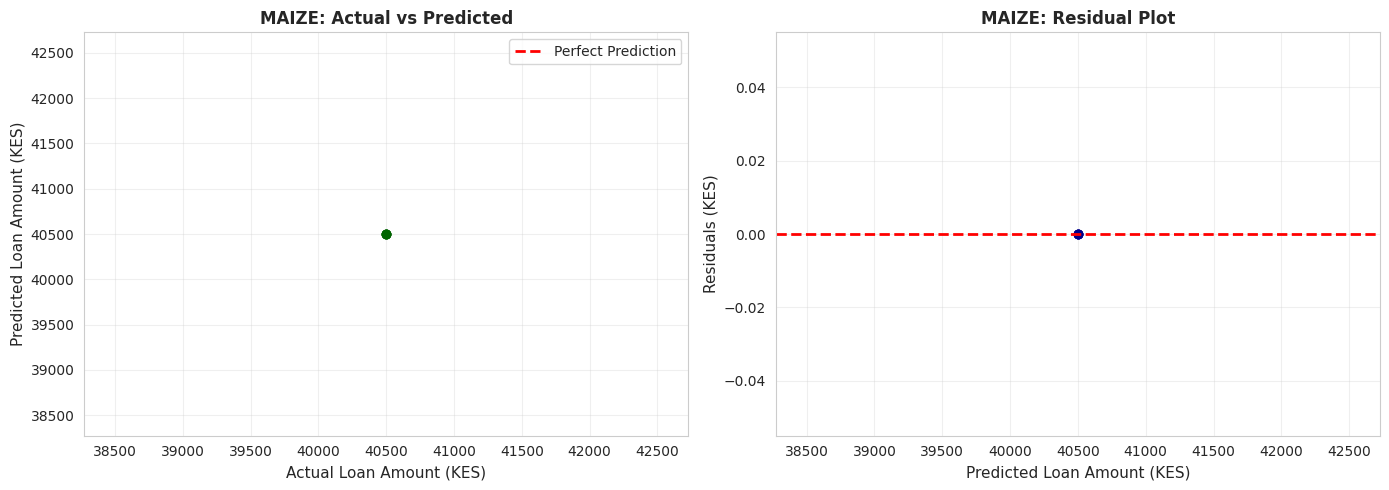

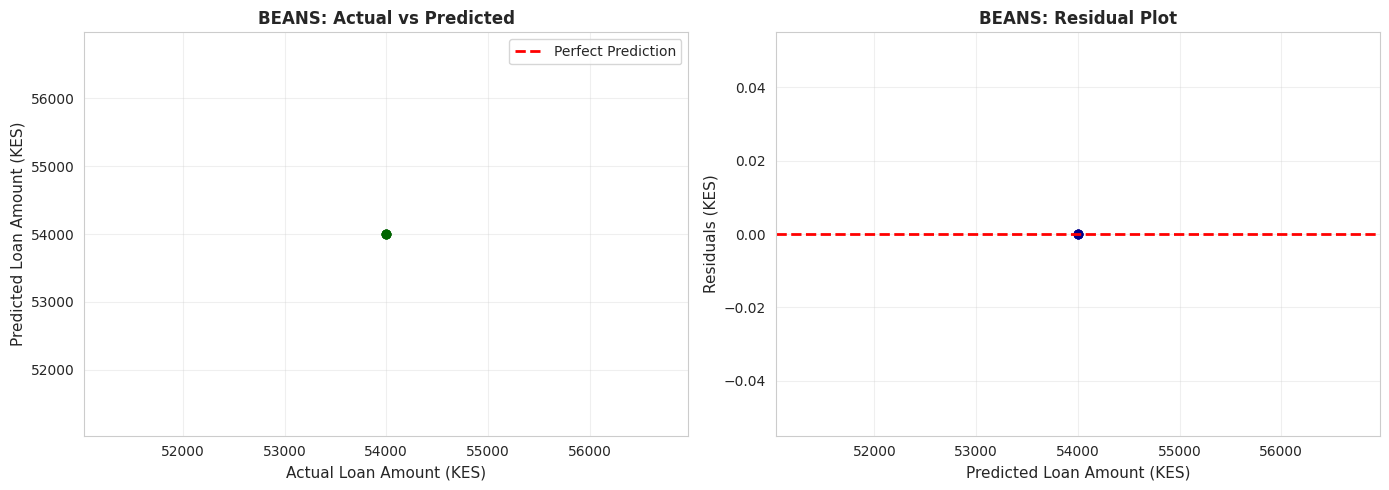

In [ ]:
def plot_predictions(y_true, y_pred, crop_name):
    """
    Visualize actual vs predicted loan amounts
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Scatter plot
    axes[0].scatter(y_true, y_pred, alpha=0.5, color='darkgreen')
    axes[0].plot([y_true.min(), y_true.max()],
                 [y_true.min(), y_true.max()],
                 'r--', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('Actual Loan Amount (KES)', fontsize=11)
    axes[0].set_ylabel('Predicted Loan Amount (KES)', fontsize=11)
    axes[0].set_title(f'{crop_name.upper()}: Actual vs Predicted', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Residuals
    residuals = y_true - y_pred
    axes[1].scatter(y_pred, residuals, alpha=0.5, color='darkblue')
    axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[1].set_xlabel('Predicted Loan Amount (KES)', fontsize=11)
    axes[1].set_ylabel('Residuals (KES)', fontsize=11)
    axes[1].set_title(f'{crop_name.upper()}: Residual Plot', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_predictions(y_test_maize, y_pred_maize, 'maize')
plot_predictions(y_test_beans, y_pred_beans, 'beans')

##  SAVE MODELS

In [ ]:
print("\n" + "="*70)
print("SAVING MODELS")
print("="*70)



SAVING MODELS


In [ ]:

# Save models and scalers
joblib.dump(model_maize, 'maize_loan_model.pkl')
joblib.dump(model_beans, 'beans_loan_model.pkl')
joblib.dump(scaler_maize, 'maize_scaler.pkl')
joblib.dump(scaler_beans, 'beans_scaler.pkl')

# Save feature names
joblib.dump(maize_feature_cols, 'maize_features.pkl')
joblib.dump(beans_feature_cols, 'beans_features.pkl')

# Save crop parameters
crop_params = {
    'maize': {'cost': maize_cost, 'yield': maize_yield},
    'beans': {'cost': beans_cost, 'yield': beans_yield}
}
joblib.dump(crop_params, 'crop_parameters.pkl')

print("\n✓ Models saved successfully!")
print("\nSaved files:")
print("  - maize_loan_model.pkl")
print("  - beans_loan_model.pkl")
print("  - maize_scaler.pkl")
print("  - beans_scaler.pkl")
print("  - maize_features.pkl")
print("  - beans_features.pkl")
print("  - crop_parameters.pkl")

# Download models
from google.colab import files
files.download('maize_loan_model.pkl')
files.download('beans_loan_model.pkl')
files.download('maize_scaler.pkl')
files.download('beans_scaler.pkl')
files.download('maize_features.pkl')
files.download('beans_features.pkl')
files.download('crop_parameters.pkl')


✓ Models saved successfully!

Saved files:
  - maize_loan_model.pkl
  - beans_loan_model.pkl
  - maize_scaler.pkl
  - beans_scaler.pkl
  - maize_features.pkl
  - beans_features.pkl
  - crop_parameters.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##  EXAMPLE PREDICTIONS

In [ ]:
print("\n" + "="*70)
print("EXAMPLE LOAN PREDICTIONS")
print("="*70)


EXAMPLE LOAN PREDICTIONS


In [ ]:
def predict_loan_for_farmer(crop_name, land_size_ha, historical_yield_pct,
                           current_price, model, scaler, features):
    """
    Predict loan amount for a specific farmer
    """
    # Get crop parameters
    if crop_name == 'maize':
        base_yield = maize_yield
        cost_per_ha = maize_cost
    else:
        base_yield = beans_yield
        cost_per_ha = beans_cost

    # Adjust yield based on farmer's historical performance
    expected_yield = base_yield * (historical_yield_pct / 100)

    # Create feature vector (simplified for demonstration)
    # In production, you'd need current market data
    feature_vector = np.zeros(len(features))
    # Set key features (you'd populate these from current data)
    avg_price_idx = [i for i, f in enumerate(features) if 'avg_price' in f and 'lag' not in f][0]
    feature_vector[avg_price_idx] = current_price

    # Scale and predict
    feature_vector_scaled = scaler.transform(feature_vector.reshape(1, -1))
    loan_per_ha = model.predict(feature_vector_scaled)[0]

    # Calculate totals
    total_loan = loan_per_ha * land_size_ha
    total_cost = cost_per_ha * land_size_ha
    expected_revenue = expected_yield * land_size_ha * current_price
    expected_profit = expected_revenue - total_cost
    roi = (expected_profit / total_loan) * 100

    return {
        'recommended_loan': total_loan,
        'total_cost': total_cost,
        'expected_revenue': expected_revenue,
        'expected_profit': expected_profit,
        'roi': roi
    }

# Example farmer scenarios
print("\n📊 FARMER SCENARIO 1: Small-scale Maize Farmer")
result1 = predict_loan_for_farmer(
    crop_name='maize',
    land_size_ha=3,
    historical_yield_pct=85,
    current_price=60,
    model=model_maize,
    scaler=scaler_maize,
    features=maize_feature_cols
)
print(f"  Land Size: 3 hectares")
print(f"  Recommended Loan: KES {result1['recommended_loan']:,.0f}")
print(f"  Expected Revenue: KES {result1['expected_revenue']:,.0f}")
print(f"  Expected Profit: KES {result1['expected_profit']:,.0f}")
print(f"  ROI: {result1['roi']:.1f}%")

print("\n📊 FARMER SCENARIO 2: Medium-scale Beans Farmer")
result2 = predict_loan_for_farmer(
    crop_name='beans',
    land_size_ha=5,
    historical_yield_pct=90,
    current_price=150,
    model=model_beans,
    scaler=scaler_beans,
    features=beans_feature_cols
)
print(f"  Land Size: 5 hectares")
print(f"  Recommended Loan: KES {result2['recommended_loan']:,.0f}")
print(f"  Expected Revenue: KES {result2['expected_revenue']:,.0f}")
print(f"  Expected Profit: KES {result2['expected_profit']:,.0f}")
print(f"  ROI: {result2['roi']:.1f}%")

print("\n" + "="*70)
print("✅ MODEL TRAINING COMPLETE!")
print("="*70)
print("\nNext Steps:")
print("1. Download the saved model files")
print("2. Integrate with your loan application system")
print("3. Use the predict_loan_for_farmer() function for new applications")
print("4. Retrain model quarterly with new price data")
print("\n" + "="*70)


📊 FARMER SCENARIO 1: Small-scale Maize Farmer
  Land Size: 3 hectares
  Recommended Loan: KES 121,500
  Expected Revenue: KES 306,000
  Expected Profit: KES 171,000
  ROI: 140.7%

📊 FARMER SCENARIO 2: Medium-scale Beans Farmer
  Land Size: 5 hectares
  Recommended Loan: KES 209,592
  Expected Revenue: KES 540,000
  Expected Profit: KES 240,000
  ROI: 114.5%

✅ MODEL TRAINING COMPLETE!

Next Steps:
1. Download the saved model files
2. Integrate with your loan application system
3. Use the predict_loan_for_farmer() function for new applications
4. Retrain model quarterly with new price data

